<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_driven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [4]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
objects_train_encoded = label_encoder.fit_transform(objects_train)

In [6]:
class SpikeData(Dataset):
    def __init__(self,stimulus,objects,label_encoder = None):
        self.stimulus = torch.tensor(stimulus)
        #self.objects = objects
        #self.labels = label_encoder.transform(objects)
        self.labels = torch.tensor(label_encoder.transform(objects))
        #self.spikes = spikes if spikes is not None else np.zeros((stimulus.shape[0], stimulus.shape[1], 1))

        self.number_of_class = np.unique(objects).shape[0]
    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        return self.stimulus[idx], self.labels[idx]

In [7]:
IT5dataloader_train = DataLoader(SpikeData(stimulus_train, objects_train, label_encoder=label_encoder), batch_size=64, shuffle=True)
IT5dataloader_val = DataLoader(SpikeData(stimulus_val,  objects_val, label_encoder=label_encoder), batch_size=64, shuffle=False)
IT5dataloader_test = DataLoader(SpikeData(stimulus_test, objects_test,label_encoder=label_encoder), batch_size=64, shuffle=False)

In [8]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)   # (3, 224, 224) → (32, 224, 224)
        self.bn1 = nn.BatchNorm2d(16)

        # Conv block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # (64, 112, 112)
        self.bn2 = nn.BatchNorm2d(32)

        # Conv block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # (128, 56, 56)
        self.bn3 = nn.BatchNorm2d(64)

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            x = self._forward_features(dummy_input)
            self.flattened_size = x.view(1, -1).shape[1]

        # FC layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def _forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)   # (32, 112, 112)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)   # (64, 56, 56)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)   # (128, 28, 28)

        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, labels in train_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                pbar.set_postfix(loss=running_loss/len(train_loader))
                pbar.update(1)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")



In [13]:
loss_fn = nn.CrossEntropyLoss()
model = ShallowCNN(num_classes=64)
model.apply(ShallowCNN.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
train_model(model, IT5dataloader_train, IT5dataloader_val, loss_fn, optimizer, num_epochs=10)

save_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
torch.save(model.state_dict(), save_path)

Epoch 1/10: 100%|██████████| 41/41 [00:03<00:00, 10.86it/s, loss=10.4]


Epoch [1/10], Loss: 10.3657
Validation Loss: 4.1590


Epoch 2/10: 100%|██████████| 41/41 [00:02<00:00, 16.26it/s, loss=4.16]


Epoch [2/10], Loss: 4.1596
Validation Loss: 4.1591


Epoch 3/10: 100%|██████████| 41/41 [00:02<00:00, 16.26it/s, loss=4.16]


Epoch [3/10], Loss: 4.1592
Validation Loss: 4.1591


Epoch 4/10: 100%|██████████| 41/41 [00:02<00:00, 16.35it/s, loss=4.16]


Epoch [4/10], Loss: 4.1592
Validation Loss: 4.1591


Epoch 5/10: 100%|██████████| 41/41 [00:02<00:00, 16.23it/s, loss=4.16]


Epoch [5/10], Loss: 4.1592
Validation Loss: 4.1593


Epoch 6/10: 100%|██████████| 41/41 [00:02<00:00, 16.17it/s, loss=4.16]


Epoch [6/10], Loss: 4.1592
Validation Loss: 4.1592


Epoch 7/10: 100%|██████████| 41/41 [00:02<00:00, 16.24it/s, loss=4.16]


Epoch [7/10], Loss: 4.1592
Validation Loss: 4.1593


Epoch 8/10: 100%|██████████| 41/41 [00:02<00:00, 16.29it/s, loss=4.16]


Epoch [8/10], Loss: 4.1591
Validation Loss: 4.1593


Epoch 9/10: 100%|██████████| 41/41 [00:02<00:00, 16.27it/s, loss=4.16]


Epoch [9/10], Loss: 4.1592
Validation Loss: 4.1594


Epoch 10/10: 100%|██████████| 41/41 [00:02<00:00, 16.30it/s, loss=4.16]


Epoch [10/10], Loss: 4.1592
Validation Loss: 4.1594


In [10]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
model = ShallowCNN(num_classes=64)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [11]:
import os
import torch
from collections import defaultdict
from pathlib import Path

# Setup
model.eval()

# Create directory to save outputs
Path("/content/drive/MyDrive/nx414/activations").mkdir(exist_ok=True)

# Function to create hook
def save_output(layer_name, batch_idx):
    def hook(module, input, output):
        # Save activations per batch to disk
        flat_output = output.detach().cpu().view(output.size(0), -1)
        torch.save(flat_output, f'/content/drive/MyDrive/nx414/activations/{layer_name}_batch{batch_idx}.pt')
    return hook

# Register hooks once
hooks = []
for name in ['conv1', 'conv2', 'conv3', 'fc1']:
    layer = getattr(model, name)
    hooks.append(layer.register_forward_hook(save_output(name, batch_idx=0)))  # Temporary index

# Iterate through data and update hook batch index
for batch_idx, (images, labels) in enumerate(IT5dataloader_train):
    images = images.to(device)

    # Update each hook with correct batch index dynamically
    for h in hooks:
        h.remove()
    hooks = []
    for name in ['conv1', 'conv2', 'conv3', 'fc1']:
        layer = getattr(model, name)
        hooks.append(layer.register_forward_hook(save_output(name, batch_idx)))

    with torch.no_grad():
        _ = model(images)

    torch.save(labels.cpu(), f'/content/drive/MyDrive/nx414/activations/labels_batch{batch_idx}.pt')

In [13]:
import glob

# Get all .pt files for the conv1 layer (sorted by batch index)
file_paths = sorted(glob.glob('activations/conv3_batch*.pt'))

# Load each file and flatten it: [batch_size, ...] -> [batch_size, n_neurons]
activations_list = []

for file_path in file_paths:
    batch = torch.load(file_path)               # shape: [batch_size, C, H, W] or [batch_size, D]
    batch_flat = batch.view(batch.size(0), -1)  # flatten to [batch_size, n_neurons]
    activations_list.append(batch_flat)

# Concatenate all batches -> [n_trials, n_neurons]
all_activations = torch.cat(activations_list, dim=0)
print(all_activations.shape)

torch.Size([2592, 200704])


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import r_regression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold

scaler = StandardScaler()
pca = PCA(n_components=1000)

X_train = scaler.fit_transform(all_activations)
X_train.shape
#X_train = pca.fit_transform(X_train)


(2592, 200704)

In [15]:
X_train = pca.fit_transform(X_train)

In [ ]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=1000, batch_size=64)
X_train_pca = ipca.fit_transform(X_train)

In [16]:
from sklearn.metrics import make_scorer
#from scipy.stats import pearsonr
# Define a scoring function compatible with make_scorer
def pearson_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        r = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        if np.isnan(r):
            r = 0
        if np.isinf(r):
            r = 0
        scores.append(r)
    return np.mean(scores)

# Wrap it as a scorer (greater_is_better=True is default)
pearson_scorer = make_scorer(pearson_score, greater_is_better=True)

In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold

# Ridge model
ridge = Ridge(max_iter=10000, tol=1e-5)

# Grid of alpha values
param_grid = {'alpha': np.logspace(-2, 4, 10)}

# GroupKFold ensures the same label distribution in each fold
cv = GroupKFold(n_splits=5)

# Wrap with GridSearchCV, pass groups
grid = GridSearchCV(ridge, param_grid, cv=cv, scoring=pearson_scorer, n_jobs=-1)

# Fit with groups controlling label distribution
grid.fit(X_train, spikes_train, groups=objects_train_encoded)

# Results
print("Best alpha:", grid.best_params_['alpha'])
print("Best pearson correlation:", grid.best_score_)

Best alpha: 10000.0
Best pearson correlation: -0.003694257467578923


In [21]:
grid.best_estimator_.fit(X_train, spikes_train)
predictions_train_ridge = grid.best_estimator_.predict(X_train)

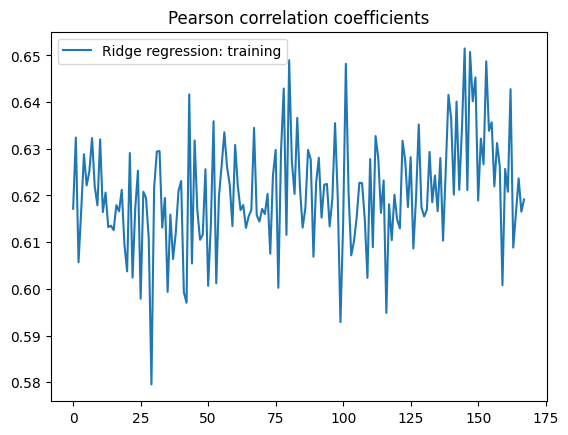

Pearson correlation on training set: 0.6206696852246076


<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_ridge = np.zeros((n_neurons,1))
for i in range(n_neurons):
    pearson_corr_ridge[i,0] = np.corrcoef(predictions_train_ridge[:, i], spikes_train[:, i])[0, 1]
    #pearson_corr_ridge[i,1] = np.corrcoef(predictions_val_ridge[:, i], spikes_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
#plt.plot(pearson_corr_ridge[:,1], label='Ridge regression: validation')
plt.plot(pearson_corr_ridge[:,0], label='Ridge regression: training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_ridge[:,0])}")
#print(f"Pearson correlation on validation set: {np.mean(pearson_corr_ridge[:,1])}")

In [25]:
!rm -r activations/